# Алгоритм построения дерева решений <a class='anchor' id='decision_tree'>

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
from sklearn.model_selection import train_test_split

### Задание 1 <a class='anchor' id='decision_tree'>

В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (min_leaf), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции build_tree и проверьте ее работоспособность с помощью визуализации дерева (функция print_tree).

In [2]:
# Сгенерируем датасет
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5)

In [3]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

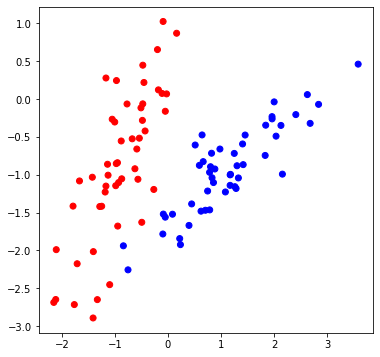

In [4]:
# Визуализация сгенерированных данных
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [5]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [6]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ', качество = ' + str(round(node.quality, 2))
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

In [7]:
# Реализуем класс узла
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)
class Leaf:
    def __init__(self, data, labels, quality):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.quality = quality
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [9]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    #min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            #if len(true_data) < min_leaf or len(false_data) < min_leaf:
            #    continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_leaf=5):
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels, quality)
    
    # Добавляем еще один критерий остановки: количество объектов в листе  
    if len(data) < min_leaf:
        return Leaf(data, labels, quality)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf)
    false_branch = build_tree(false_data, false_labels, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 1)
print_tree(my_tree)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6, качество = 0
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.49
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = -0.84
            --> Левая ветка:
                ЛИСТ: прогноз = 1, объектов = 1, качество = 0
            --> Правая ветка:
                ЛИСТ: прогноз = 0, объектов = 1, качество = 0
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 4, качество = 0
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28, качество = 0
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30, качество = 0


In [15]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 5)
print_tree(my_tree)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6, качество = 0
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.49
         --> Левая ветка:
             ЛИСТ: прогноз = 1, объектов = 2, качество = 0.5
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 4, качество = 0
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28, качество = 0
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30, качество = 0


In [16]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 15)
print_tree(my_tree)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
       ЛИСТ: прогноз = 0, объектов = 12, качество = 0.35
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28, качество = 0
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30, качество = 0
